## Imports

In [13]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

import sys
import pickle
import wandb

import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.utils import to_networkx
import torch.nn as nn
from torch.nn import Sequential, Linear
import networkx as nx
import wntr

from utils.miscellaneous import read_config
from utils.miscellaneous import create_folder_structure_MLPvsGNN
from utils.miscellaneous import initalize_random_generators
from utils.wandb_logger import log_wandb_data

from training.train import training
from training.test import testing

from utils.visualization import plot_R2, plot_loss
from matplotlib	import pyplot as plt

### Parse configuration file + initializations


In [14]:
# read config files
cfg = read_config("config_unrolling.yaml")
# create folder for result
exp_name = cfg['exp_name']
data_folder = cfg['data_folder']
results_folder = create_folder_structure_MLPvsGNN(cfg, parent_folder='./experiments')


all_wdn_names = cfg['networks']
initalize_random_generators(cfg, count=0)

# initialize pytorch device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#torch.set_num_threads(12)

Creating folder: ./experiments/unrolling_WDN0001
cpu


In [15]:
# TO DO: at the moment I am not using the parsed values for batch size and num_epochs ;
# I am not using alpha as well because the loss has no "smoothness" penalty (yet)
batch_size = cfg['trainParams']['batch_size']
num_epochs = cfg['trainParams']['num_epochs']
alpha = cfg['lossParams']['alpha']
res_columns = ['train_loss', 'valid_loss','test_loss','max_train_loss', 'max_valid_loss','max_test_loss', 'min_train_loss', 'min_valid_loss','min_test_loss','r2_train', 'r2_valid',
			   'r2_test','total_params','total_time','test_time']

# Functions

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator,TransformerMixin

class PowerLogTransformer(BaseEstimator,TransformerMixin):
	def __init__(self,log_transform=False,power=4,reverse=True):
		if log_transform == True:
			self.log_transform = log_transform
			self.power = None
		else:
			self.power = power
			self.log_transform = None
		self.reverse=reverse
		self.max_ = None
		self.min_ = None

	def fit(self,X,y=None):
		self.max_ = np.max(X)
		self.min_ = np.min(X)
		return self

	def transform(self,X):
		if self.log_transform==True:
			if self.reverse == True:
				return np.log1p(self.max_-X)
			else:
				return np.log1p(X-self.min_)
		else:
			if self.reverse == True:
				return (self.max_-X)**(1/self.power )
			else:
				return (X-self.min_)**(1/self.power )

	def inverse_transform(self,X):
		if self.log_transform==True:
			if self.reverse == True:
				return (self.max_ - np.exp(X))
			else:
				return (np.exp(X) + self.min_)
		else:
			if self.reverse == True:
				return (self.max_ - X**self.power )
			else:
				return (X**self.power + self.min_)


class GraphNormalizer:
	def __init__(self, x_feat_names=['head', 'base_demand'],
				 ea_feat_names=['diameter', 'length', 'roughness'], output='pressure'):
		# store
		self.x_feat_names = x_feat_names
		self.ea_feat_names = ea_feat_names
		self.output = output

		# create separate scaler for each feature (can be improved, e.g., you can fit a scaler for multiple columns)
		self.scalers = {}
		for feat in self.x_feat_names:
			if feat == 'elevation':
				self.scalers[feat] = PowerLogTransformer(log_transform=True, reverse=False)
			else:
				self.scalers[feat] = MinMaxScaler()
		self.scalers[output] = PowerLogTransformer(log_transform=True, reverse=True)
		for feat in self.ea_feat_names:
			if feat == 'length':
				self.scalers[feat] = PowerLogTransformer(log_transform=True, reverse=False)
			else:
				self.scalers[feat] = MinMaxScaler()

	def fit(self, graphs):
		''' Fit the scalers on an array of x and ea features
        '''
		x, y, ea = from_graphs_to_pandas(graphs)
		
		for ix, feat in enumerate(self.x_feat_names):
			self.scalers[feat] = self.scalers[feat].fit(x[:, ix].reshape(-1, 1))
			
		self.scalers[self.output] = self.scalers[self.output].fit(y.reshape(-1, 1))
		
		for ix, feat in enumerate(self.ea_feat_names):
			self.scalers[feat] = self.scalers[feat].fit(ea[:, ix].reshape(-1, 1))
			
		return self

	def transform(self, graph):
		''' Transform graph based on normalizer
        '''
		graph = graph.clone()
		for ix, feat in enumerate(self.x_feat_names):
			temp = graph.x[:, ix].numpy().reshape(-1, 1)
			graph.x[:, ix] = torch.tensor(self.scalers[feat].transform(temp).reshape(-1))
		for ix, feat in enumerate(self.ea_feat_names):
			temp = graph.edge_attr[:, ix].numpy().reshape(-1, 1)
			graph.edge_attr[:, ix] = torch.tensor(self.scalers[feat].transform(temp).reshape(-1))
		
		if isinstance(graph.y, list):
			transformed_y = []
			for i, el in enumerate(graph.y):
				transformed_y.append(torch.tensor(self.scalers[self.output].transform(graph.y[i].numpy().reshape(-1, 1)).reshape(-1)))
			graph.y = transformed_y
		else:
			graph.y = torch.tensor(self.scalers[self.output].transform(graph.y.numpy().reshape(-1, 1)).reshape(-1))
		return graph

	def inverse_transform(self, graph):
		''' Perform inverse transformation to return original features
        '''
		graph = graph.clone()
		for ix, feat in enumerate(self.x_feat_names):
			temp = graph.x[:, ix].numpy().reshape(-1, 1)
			graph.x[:, ix] = torch.tensor(self.scalers[feat].inverse_transform(temp).reshape(-1))
		for ix, feat in enumerate(self.ea_feat_names):
			temp = graph.edge_attr[:, ix].numpy().reshape(-1, 1)
			graph.edge_attr[:, ix] = torch.tensor(self.scalers[feat].inverse_transform(temp).reshape(-1))
		graph.y = torch.tensor(self.scalers[self.output].inverse_transform(graph.y.numpy().reshape(-1, 1)).reshape(-1))
		return graph

	def transform_array(self, z, feat_name):
		'''
            This is for MLP dataset; it can be done better (the entire thing, from raw data to datasets)
        '''
		return torch.tensor(self.scalers[feat_name].transform(z).reshape(-1))

	def inverse_transform_array(self, z, feat_name):
		'''
            This is for MLP dataset; it can be done better (the entire thing, from raw data to datasets)
        '''
		return torch.tensor(self.scalers[feat_name].inverse_transform(z).reshape(-1))

def from_graphs_to_pandas(graphs):
	x = []
	y = []
	ea = []
	for i, graph in enumerate(graphs):
		x.append(graph.x.numpy())
		
		if isinstance(graph.y, list):
			
			y.append(np.concatenate(graph.y, axis=0))
		else:
			y.append(graph.y.numpy())

		ea.append(graph.edge_attr.numpy())
	
	return np.concatenate(x, axis=0), np.concatenate(y, axis=0), np.concatenate(ea, axis=0)


In [17]:
# constant indexes for node and edge features
HEAD_INDEX = 0 # Elevation + base head + initial level
BASEDEMAND_INDEX = 1 
TYPE_INDEX = 2 
NODE_DIAMETER_INDEX = 3 # Needed for tanks
LEVEL_INDEX = 4 # Needed for tanks
DIAMETER_INDEX = 0 
LENGTH_INDEX = 1 
ROUGHNESS_INDEX = 2 
FLOW_INDEX = 3 

def load_raw_dataset(wdn_name, data_folder):
	'''
	Load tra/val/data for a water distribution network datasets
	-------
	wdn_name : string
		prefix of pickle files to open
	data_folder : string
		path to datasets
	'''

	data_tra = pickle.load(open(f'{data_folder}/train/{wdn_name}.p', "rb"))
	data_val = pickle.load(open(f'{data_folder}/valid/{wdn_name}.p', "rb"))
	data_tst = pickle.load(open(f'{data_folder}/test/{wdn_name}.p', "rb"))

	return data_tra, data_val, data_tst

def create_dataset(database, normalizer=None, output='pressure'):
	'''
	Creates working datasets dataset from the pickle databases
	------
	database : list
		each element in the list is a pickle file containing Data objects
	normalization: dict
		normalize the dataset using mean and std
	'''

	graphs = []

	for i in database:
		
		graph = torch_geometric.data.Data()

		# Node attributes
		# min_elevation = min(i.elevation[i.type_1H == 0])
		
		# The head below is junctions plus reservoirs (plus tanks when implemented)
		head = i.pressure + i.base_head + i.elevation + i.initial_level
		# type_1H is equal to 1 when the node is a reservoir and 2 when it's a tank
		
		# We want to make the tuple that constructs a node of any type
		graph.x = torch.stack((i.elevation + i.base_head + i.initial_level, i.base_demand, i.type_1H, i.node_diameter), dim=1).float()
		# graph.x = torch.stack((i.elevation + i.base_head, i.base_demand, i.type_1H), dim=1).float()

		# Position and ID
		graph.pos = i.pos
		graph.ID = i.ID

		# Edge index (Adjacency matrix)
		graph.edge_index = i.edge_index

		# Edge attributes
		diameter = i.diameter
		length = i.length
		roughness = i.roughness
		graph.edge_attr = torch.stack((diameter, length, roughness), dim=1).float()

		# If the length of the shape of pressure was 2 then it means that the simulation was continuous
		press_shape = i.pressure.shape
		if len(press_shape) == 2:
			graph.y = []
			for time_step in range(press_shape[0]):
				# Also appending tanks to the output since their pressures also need to be predicted like any other node
				# The code below actually appends everything that isn't a reservoir
				# Make below statement check if type_1H == 0 or 2 instead of != 1
				graph.y.append(i.pressure[time_step][[(i.type_1H == 0) | (i.type_1H == 2)]].reshape(-1, 1))
		else:
			# Graph output (head)
			if output == 'head':
				graph.y  = head[i.type_1H == 0].reshape(-1, 1)
			else:
				graph.y = i.pressure[i.type_1H == 0].reshape(-1, 1)
		# normalization
		if normalizer is not None:
			graph = normalizer.transform(graph)

		graphs.append(graph)
		
	A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()
	return graphs, A12

def create_dataset_MLP_from_graphs(graphs, features=['nodal_demands', 'base_heads','diameter','roughness','length', 'nodal_diameters'],no_res_out=True):

	# index edges to avoid duplicates: this considers all graphs to be UNDIRECTED!
	ix_edge = graphs[0].edge_index.numpy().T
	ix_edge = (ix_edge[:, 0] < ix_edge[:, 1])

	# position of reservoirs, and tanks
	# reservoir type is 1, tank is 2
	ix_junct = graphs[0].x[:,TYPE_INDEX].numpy()==0
	ix_res = graphs[0].x[:,TYPE_INDEX].numpy()==1
	ix_tank = graphs[0].x[:,TYPE_INDEX].numpy()==2
	indices = {}
	prev_feature = None
	for ix_feat, feature in enumerate(features):
		for ix_item, item in enumerate(graphs):
			if feature == 'diameter':
				x_ = item.edge_attr[ix_edge,DIAMETER_INDEX]
			elif feature == 'roughness':
				# remove reservoirs
				x_ = item.edge_attr[ix_edge,ROUGHNESS_INDEX]
			elif feature == 'length':
				# remove reservoirs
				x_ = item.edge_attr[ix_edge,LENGTH_INDEX]
			elif feature == 'nodal_demands':
				# remove reservoirs
				x_ = item.x[ix_junct,BASEDEMAND_INDEX]
			elif feature == 'nodal_diameters':
				# Only get diameters for 
				x_ = item.x[ix_tank,NODE_DIAMETER_INDEX]
			elif feature == 'base_heads':
				# filter below on ix_res or ix_tank
				ix_res_or_tank = np.logical_or(ix_res, ix_tank)
				x_ = item.x[ix_res_or_tank,HEAD_INDEX]
			elif feature == 'tank_level':
				x_ = item.x[ix_tank,LEVEL_INDEX]	
			else:
				raise ValueError(f'Feature {feature} not supported.')
			
			if ix_item == 0:
				x = x_
			else:
				x = torch.cat((x, x_), dim=0)
		
	
		if ix_feat == 0:
			X = x.reshape(len(graphs), -1)
		else:
			X = torch.cat((X, x.reshape(len(graphs), -1)), dim=1)
		
		if prev_feature:
			indices[feature] = slice(indices[prev_feature].stop, X.shape[1], 1)
		else:
			indices[feature] = slice(0, X.shape[1], 1)
		
		prev_feature = feature
	
	for ix_item, item in enumerate(graphs):
		# remove reservoirs from y as well
		if ix_item == 0:
			if no_res_out:
				if isinstance(item.y, list):
					y = torch.stack(item.y).unsqueeze(0).expand(1, -1, -1)
				else:
					y = item.y
			else:
				y = item.y[ix_junct]
			
		else:
			if no_res_out:
				if isinstance(item.y, list):
					y = torch.cat((y, torch.stack(item.y).unsqueeze(0).expand(1, -1, -1)), dim=0)
				else:
					y = torch.cat((y, item.y), dim=0)
			else:
				y = torch.cat((y, item.y[ix_junct]), dim=0)
				
	
	# If the shape of y is 1D then it means that the simulation was single period and should be turned to 2D according to the amount of graphs, if 3D then it was continuous
	if len(y.shape) == 1:
		y = y.reshape(len(graphs), -1)
	# SOMEWHERE HERE THE SEQUENCE LENGTH NEEDS TO BE ADJUSTED
	return torch.utils.data.TensorDataset(X, y), X.shape[1], indices

def create_incidence_matrices(graphs,incidence_matrix):

	# position of reservoirs

	ix_junct = graphs[0].x[:,TYPE_INDEX].numpy()==0
	ix_edge = graphs[0].edge_index.numpy().T
	ix_edge = (ix_edge[:, 0] < ix_edge[:, 1])
	incidence_matrix = incidence_matrix[ix_edge,:]
	# The A12 incidence matrix is definitely only junctions, but should the A10 include tanks?
	A10 = incidence_matrix[:, ~ix_junct]
	A12 = incidence_matrix[:, ix_junct]
	A12[np.where(A10 == 1),:] *= -1
	A10[np.where(A10 == 1),:] *= -1
	return A10, A12

## Models
I will be Creating different models as follows:

* A simple LSTM
* An unrolled version of Heads and Flows, without static variables
* An unrolled version with Heads, Flows and static variables


In [18]:
class MLP(nn.Module):
	def __init__(self, num_outputs, hid_channels, indices, num_layers=6):
		super(MLP, self).__init__()
		torch.manual_seed(42)
		self.hid_channels = hid_channels
		self.indices = indices
		
		self.total_input_length = indices[list(indices.keys())[-1]].stop
		
		layers = [Linear(self.total_input_length, hid_channels),
				  nn.ReLU()]

		for l in range(num_layers-1):
			layers += [Linear(hid_channels, hid_channels),
					   nn.ReLU()]

		layers += [Linear(hid_channels, num_outputs)]

		self.main = nn.Sequential(*layers)

	def forward(self, x, num_steps=1):

		x = self.main(x)

		return x

In [19]:
import torch.nn.init as init
# Define your LSTM model class
class LSTM(nn.Module):
	def __init__(self, num_outputs, hid_channels, indices, num_layers=2):
		super(LSTM, self).__init__()
		self.hidden_size = hid_channels
		self.num_layers = num_layers
		self.output_size = num_outputs
		self.input_size = indices[list(indices.keys())[-1]].stop
		
		# Define the LSTM layer
		self.lstm = nn.LSTM(self.input_size + self.output_size, self.hidden_size, num_layers, batch_first=True)

		
		# Define the output layer
		self.linear = nn.Linear(self.hidden_size, self.output_size)
			

	def forward(self, static_input, num_steps=25):
		# Initialize hidden state with zeros
		# x = x.unsqueeze(1)
		batch_size = static_input.size(0)
		
		# Initial hidden state and cell state
		h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(static_input.device)
		c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(static_input.device)
		
		# Initialize the output sequence with zeros
		output_seq = torch.zeros(batch_size, num_steps, self.output_size).to(static_input.device)
		
		repeated_static_input = static_input.unsqueeze(1).repeat(1, 1, 1)
		# print(repeated_static_input.shape, static_input.shape, output_seq.shape)
		 # Iterate through time steps
		for t in range(num_steps):
			# Concatenate static_input with the previous output (if available)
			if t == 0:
				lstm_input = torch.cat((repeated_static_input, output_seq[:, t:t+1, :]), dim=-1)
			else:
				lstm_input = torch.cat((repeated_static_input, output_seq[:, t-1:t, :]), dim=-1)
				
			h0 = h0.to(torch.double)
			c0 = c0.to(torch.double)
			# Forward pass through the LSTM
			lstm_output, (h0, c0) = self.lstm(lstm_input, (h0, c0))
		
			# Predict the output for the current time step
			
			output_seq[:, t:t+1, :] = self.linear(lstm_output)
		
		return output_seq.to(torch.double)

In [20]:
class BaselineUnrolling(nn.Module):
	def __init__(self,num_outputs, indices, num_blocks):
		super(BaselineUnrolling, self).__init__()
		torch.manual_seed(42)
		self.indices = indices
		self.num_heads = indices['nodal_demands'].stop
		self.num_flows = indices['diameter'].stop-indices['diameter'].start
		self.num_base_heads = indices['base_heads'].stop-indices['base_heads'].start
		self.num_blocks = num_blocks
		self.n = 1.852

		self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
		
		
		self.hid_HF = nn.ModuleList()
		self.hid_FH = nn.ModuleList()

		for i in range(num_blocks):
			self.hid_HF.append(Sequential(Linear(self.num_heads, self.num_flows), nn.ReLU()))
			self.hid_FH.append(Sequential(Linear(self.num_flows, self.num_heads), nn.ReLU()))

		self.out = Linear(self.num_heads, num_outputs)

	def forward(self, x, num_steps=1):
		
		s, h0, d, c, l = torch.unsqueeze(x[:,self.indices['nodal_demands']],dim=2), \
							   torch.unsqueeze(x[:,self.indices['base_heads']],dim=2), \
							   x[:,self.indices['diameter']].double().view(-1,self.num_flows,1),\
								x[:,self.indices['roughness']].double().view(-1,self.num_flows,1),\
								x[:,self.indices['length']].double().view(-1,self.num_flows,1)

		q =  torch.mul(math.pi/4, torch.pow(d,2)).view(-1,self.num_flows)

		
		predictions = []
		for step in range(num_steps):
			for j in range(self.num_blocks):
				h = self.hid_FH[j](q)
				q = q - self.hid_HF[j](h)


			# Append the prediction for the current time step
			prediction = self.out(h)
			predictions.append(prediction)
		
		if num_steps == 1:
			return predictions[0]
		# Convert the list of predictions to a tensor
		predictions = torch.stack(predictions, dim=1)	
		
		return predictions

In [21]:
class UnrollingModel(nn.Module):
	def __init__(self, num_outputs, indices, num_blocks):
		super(UnrollingModel, self).__init__()
		torch.manual_seed(42)
		self.indices = indices		
		self.num_heads = indices['nodal_demands'].stop
		self.num_flows = indices['diameter'].stop-indices['diameter'].start
		self.num_base_heads = indices['base_heads'].stop-indices['base_heads'].start
		self.num_blocks = num_blocks

		self.hidq0_h = Linear(self.num_flows, self.num_heads) #4.14
		self.hidh0_q = Linear(self.num_base_heads, self.num_flows) #4.8
		self.hidh0_h = Linear(self.num_base_heads, self.num_heads) #4.7
		self.hids_q =  Linear(self.num_heads, self.num_flows) #4.6
		# Below makes no sense and is not included in any of the equations of the paper. 
		self.hid_S = Sequential(Linear(indices['length'].stop - indices['diameter'].start, self.num_flows), nn.ReLU()) #???

		self.hid_hf = nn.ModuleList()
		self.hid_fh = nn.ModuleList()
		self.resq = nn.ModuleList()
		self.hidA_q = nn.ModuleList()
		self.hidD_h = nn.ModuleList()

		for i in range(num_blocks):
			self.hid_hf.append(Sequential(Linear(self.num_heads,self.num_flows), nn.PReLU()))
			self.hid_fh.append(Sequential(Linear(self.num_flows, self.num_heads), nn.ReLU()))
			self.resq.append(Sequential(Linear(self.num_flows,self.num_heads), nn.ReLU()))
			self.hidA_q.append(Sequential(Linear(self.num_flows,self.num_flows)))
			self.hidD_h.append(Sequential(Linear(self.num_flows,self.num_heads), nn.ReLU()))

		self.out = Linear(self.num_flows, num_outputs)

	def forward(self, x, num_steps=1):
		# s is indeed the demand and h0 is indeed the heads (perhaps different when tanks are added), but q is definitely not flows, it is actually diameter and then hid_S is roughness and length
		s, h0, d, edge_features = x[:,self.indices['nodal_demands']], x[:,self.indices['base_heads']], x[:,self.indices['diameter']], x[:,self.indices['diameter'].start:self.indices['length'].stop]
		
		res_h0_q, res_s_q, res_h0_h, res_S_q = self.hidh0_q(h0), self.hids_q(s), self.hidh0_h(h0), self.hid_S(edge_features)
		
		q =  torch.mul(math.pi/4, torch.pow(d,2))
		res_q_h = self.hidq0_h(q)
		
		predictions = []
		for step in range(num_steps):
			for i in range(self.num_blocks):
	
				A_q = self.hidA_q[i](torch.mul(q, res_S_q)) # 4.17
				D_h = self.hidD_h[i](A_q) # 4.16
				hid_x = torch.mul(A_q,torch.sum(torch.stack([q, res_s_q, res_h0_q]),dim=0)) # 4.18 (inside parentheses)
				h = self.hid_fh[i](hid_x) # 4.18
				hid_x = self.hid_hf[i](torch.mul(torch.sum(torch.stack([h,res_h0_h,res_q_h]),dim=0), D_h)) # 4.19 (inside parentheses)
				q = torch.sub(q,hid_x) # 4.19
				res_q_h = self.resq[i](q)

			# Append the prediction for the current time step
			prediction = self.out(q)
			predictions.append(prediction)
		
		if num_steps == 1:
			return predictions[0]
		# Convert the list of predictions to a tensor
		predictions = torch.stack(predictions, dim=1)	
		
		return predictions

## Running experiments

In [22]:

for ix_wdn, wdn in enumerate(all_wdn_names):
	print(f'\nWorking with {wdn}, network {ix_wdn+1} of {len(all_wdn_names)}')

	# retrieve wntr data
	tra_database, val_database, tst_database = load_raw_dataset(wdn, data_folder)
	# reduce training data
	# tra_database = tra_database[:int(len(tra_database)*cfg['tra_prc'])]
	if cfg['tra_num'] < len(tra_database):
		tra_database = tra_database[:cfg['tra_num']]

	# remove PES anomaly
	if wdn == 'PES':
		if len(tra_database)>4468:
			del tra_database[4468]
			print('Removed PES anomaly')
			print('Check',tra_database[4468].pressure.mean())

	# get GRAPH datasets    
	# later on we should change this and use normal scalers from scikit (something is off here)
	tra_dataset, A12_bar = create_dataset(tra_database)
	
	gn = GraphNormalizer()
	gn = gn.fit(tra_dataset)
	# The normalization messed with the 1H_type since we want unique IDs
	tra_dataset, _ = create_dataset(tra_database,normalizer=gn)
	val_dataset,_ = create_dataset(val_database,normalizer=gn)
	tst_dataset,_ = create_dataset(tst_database,normalizer=gn)
	node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)
	# number of nodes
	n_nodes = (tra_database[0].type_1H == 0).numpy().sum() + (tra_database[0].type_1H == 2).numpy().sum() # remove reservoirs
	# dataloader
	# transform dataset for MLP
	# We begin with the MLP versions, when I want to add GNNs, check Riccardo's code
	A10,A12 = create_incidence_matrices(tra_dataset, A12_bar)
	tra_dataset_MLP, num_inputs, indices = create_dataset_MLP_from_graphs(tra_dataset)
	val_dataset_MLP = create_dataset_MLP_from_graphs(val_dataset)[0]
	tst_dataset_MLP = create_dataset_MLP_from_graphs(tst_dataset)[0]
	tra_loader = torch.utils.data.DataLoader(tra_dataset_MLP,
											 batch_size=batch_size, shuffle=True, pin_memory=True)
	val_loader = torch.utils.data.DataLoader(val_dataset_MLP,
											 batch_size=batch_size, shuffle=False, pin_memory=True)
	tst_loader = torch.utils.data.DataLoader(tst_dataset_MLP,
											 batch_size=batch_size, shuffle=False, pin_memory=True)
	# loop through different algorithms
	for algorithm in cfg['algorithms']:
		# Importing of configuration parameters
		hyperParams = cfg['hyperParams'][algorithm]
		all_combinations = ParameterGrid(hyperParams)


		# create results dataframe
		results_df = pd.DataFrame(list(all_combinations))
		results_df = pd.concat([results_df,
								pd.DataFrame(index=np.arange(len(all_combinations)),
										  columns=list(res_columns))],axis=1)

		for i, combination in enumerate(all_combinations):
			wandb.init(project="unrolling-epanet")
			print(f'{algorithm}: training combination {i+1} of {len(all_combinations)}\n')
			combination['indices'] = indices
			combination['num_outputs'] = n_nodes
			
			# model creation
			model = getattr(sys.modules[__name__], algorithm)(**combination).double().to(device)
			
			# get combination dictionary to determine how are indices made
			# print("Model", model, combination) 
			
			total_parameters = sum(p.numel() for p in model.parameters())

			# model optimizer
			optimizer = optim.Adam(params=model.parameters(),betas=(0.9, 0.999), **cfg['adamParams'])

			# training
			patience = 50
			lr_rate = 2
			lr_epoch = 500
			train_config = {"Patience": patience, "Learning Rate Divisor": lr_rate, "LR Epoch Division": lr_epoch}
			model, tra_losses, val_losses, elapsed_time = training(model, optimizer, tra_loader, val_loader,
																	patience=patience, report_freq=0, n_epochs=num_epochs,
																   alpha=alpha, lr_rate=lr_rate, lr_epoch=lr_epoch,
															   normalization=None, path = f'{results_folder}/{wdn}/{algorithm}/')
			loss_plot = plot_loss(tra_losses,val_losses,f'{results_folder}/{wdn}/{algorithm}/loss/{i}')
			R2_plot = plot_R2(model,val_loader,f'{results_folder}/{wdn}/{algorithm}/R2/{i}', normalization=gn)[1]
			# store training history and model
			pd.DataFrame(data = np.array([tra_losses, val_losses]).T).to_csv(
				f'{results_folder}/{wdn}/{algorithm}/hist/{i}.csv')
			torch.save(model, f'{results_folder}/{wdn}/{algorithm}/models/{i}.csv')

			# compute and store predictions, compute r2 scores
			losses = {}
			max_losses = {}
			min_losses = {}
			r2_scores = {}
			for split, loader in zip(['training','validation','testing'],[tra_loader,val_loader,tst_loader]):
				losses[split], max_losses[split], min_losses[split], pred, real, test_time = testing(model, loader, normalization=gn)
				r2_scores[split] = r2_score(real, pred)
				if i == 0:
					pd.DataFrame(data=real.reshape(-1,n_nodes)).to_csv(
						f'{results_folder}/{wdn}/{algorithm}/pred/{split}/real.csv') # save real obs
				pd.DataFrame(data=pred.reshape(-1,n_nodes)).to_csv(
					f'{results_folder}/{wdn}/{algorithm}/pred/{split}/{i}.csv')
			
			
			# log_wandb_data(combination, wdn, algorithm, len(tra_database), len(val_database), len(tst_database), cfg, train_config, loss_plot, R2_plot)
			# store results
			results_df.loc[i,res_columns] = (losses['training'], losses['validation'], losses['testing'],
											 max_losses['training'], max_losses['validation'], max_losses['testing'],
											 min_losses['training'], min_losses['validation'], min_losses['testing'],
											 r2_scores['training'], r2_scores['validation'], r2_scores['testing'],
											 total_parameters, elapsed_time, test_time)
			
			_,_,_, pred, real, time = testing(model, val_loader)
			pred = pred.reshape(-1,n_nodes)
			real = real.reshape(-1,n_nodes)
			
			for i in [0, 1, 7, 36]:
				plt.plot(real[0:24, i], label="Real")
				plt.plot(pred[0:24, i], label="Predicted")
				plt.ylabel('Head')
				plt.xlabel('Timestep')
				plt.legend()
				wandb.log({f'Node {i}': wandb.Image(plt)})
				plt.close()
			
			wandb.finish()
		# save graph normalizer
		with open(f'{results_folder}/{wdn}/{algorithm}/gn.pickle', 'wb') as handle:
		     pickle.dump(gn, handle, protocol=pickle.HIGHEST_PROTOCOL)

		with open(f'{results_folder}/{wdn}/{algorithm}/model.pickle', 'wb') as handle:
			torch.save(model, handle)
		results_df.to_csv(f'{results_folder}/{wdn}/{algorithm}/results_{algorithm}.csv')
		
		


Working with FOS_tank, network 1 of 1


wandb: Currently logged in as: mertz. Use `wandb login --relogin` to force relogin


LSTM: training combination 1 of 4


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


LSTM: training combination 2 of 4


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


LSTM: training combination 3 of 4


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


LSTM: training combination 4 of 4


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Error: You must call wandb.init() before wandb.log()

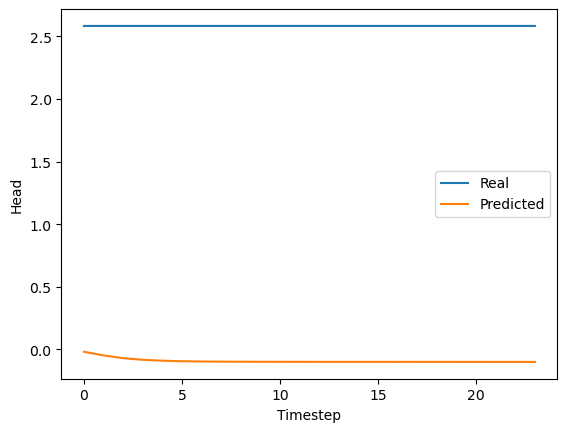

In [23]:
from utils.Dashboard import Dashboard
from IPython.display import display
import plotly.io as pio

_,_,_, pred, real, time = testing(model, val_loader)
pred = pred.reshape(-1,n_nodes)
real = real.reshape(-1,n_nodes)

# Array below is created to ensure proper indexing of the nodes when displaying
type_array = (val_database[0].type_1H == 0) | (val_database[0].type_1H == 2)
d = Dashboard(pd.DataFrame(real[0:24, :]),pd.DataFrame(pred[0:24, :]),to_networkx(val_dataset[0],node_attrs=['pos', 'ID']),type_array)
f = d.display_results()

for i in [0, 1, 7, 36]:
	plt.plot(real[0:24, i], label="Real")
	plt.plot(pred[0:24, i], label="Predicted")
	plt.ylabel('Head')
	plt.xlabel('Timestep')
	plt.legend()
	# wandb.log({f'Node {i}': wandb.Image(plt)})
	plt.close()

# Create a table

# Add Plotly figure as HTML file into Table
# table = wandb.Table(columns = ["Figure" + str(i)])
# with open('./my_HTML_' + str(i) + '.html', 'r', encoding='utf-8') as file:
# 	html_content = file.read()
# table.add_data(wandb.Html(html_content))
display(f)
# wandb.finish()

In [ ]:
import os
import regex as re
# Directory path where you want to search
directory_path = "./experiments"

# Get a list of all subdirectories in the specified directory
subdirectories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# Filter and extract the numbers from directory names
wdn_numbers = []
for subdir in subdirectories:
    match = re.match(r'unrolling_WDN(\d{4})', subdir)
    if match:
        wdn_numbers.append(int(match.group(1)))

# Find the latest WDN number
latest_wdn_number = None
if wdn_numbers:
    latest_wdn_number = max(wdn_numbers)
    latest_wdn_folder = f'unrolling_WDN{latest_wdn_number:04d}'
    print(f"The latest WDN folder is: {latest_wdn_folder}")
else:
    print("No WDN folders found in the specified directory.")

if latest_wdn_folder is not None:
	real = pd.read_csv(f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/LSTM/pred/testing/real.csv').drop(columns=['Unnamed: 0'])
	lstm_pred = pd.read_csv(f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/LSTM/pred/testing/0.csv').drop(columns=['Unnamed: 0'])
	unrolling_pred =  pd.read_csv(f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/BaselineUnrolling/pred/testing/0.csv').drop(columns=['Unnamed: 0'])

In [ ]:
import matplotlib.pyplot as plt
# Not sure if below makes sense since we now have an extra dimension
res = real.sub(lstm_pred).pow(2).sum(axis=0)
tot = real.sub(lstm_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_lstm = 1 - res/tot
res = real.sub(unrolling_pred).pow(2).sum(axis=0)
tot = real.sub(unrolling_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_unrolling = 1 - res/tot
r2s = pd.concat([r2_lstm,r2_unrolling],axis=1).rename(columns={0:'LSTM',1:'Base-U'})
fig, ax = plt.subplots()
r2s.plot.box(ax=ax)
ax.set_title("$R^2$ Scores Comparison for PES")
ax.set_ylabel('$R^2$ Score')
plt.show()

In [ ]:
model = torch.load(f'{results_folder}/{wdn}/{algorithm}/model.pickle')